In [ ]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
mypath = "/content/drive/MyDrive/SCAAI/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 


In [ ]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 

In [ ]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [ ]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files


In [ ]:
p_diag = pd.read_csv("/content/drive/MyDrive/SCAAI/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [ ]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [ ]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)


Finished feature extraction from  920  files


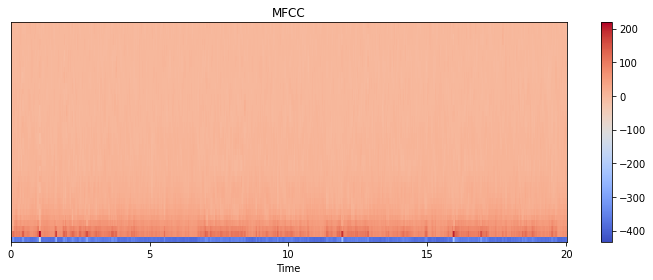

In [ ]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [ ]:
features = np.array(features) # convert to numpy array

In [ ]:
# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [ ]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


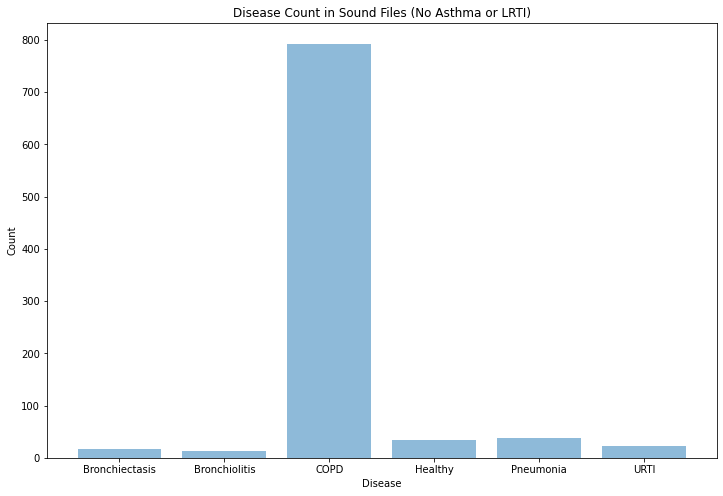

In [ ]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [ ]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 

In [ ]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [ ]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

In [ ]:
#Training Model 

In [ ]:
# train model
num_epochs = 250
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
history

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
6/6 [==============================] - 18s 3s/step - loss: 0.0842 - accuracy: 0.9645 - val_loss: 0.7731 - val_accuracy: 0.8696

Epoch 00001: val_accuracy improved from -inf to 0.86957, saving model to mymodel2_01.h5
Epoch 2/250
6/6 [==============================] - 19s 3s/step - loss: 0.0700 - accuracy: 0.9754 - val_loss: 0.6850 - val_accuracy: 0.8750

Epoch 00002: val_accuracy improved from 0.86957 to 0.87500, saving model to mymodel2_02.h5
Epoch 3/250
6/6 [==============================] - 18s 3s/step - loss: 0.0622 - accuracy: 0.9754 - val_loss: 0.7228 - val_accuracy: 0.8804

Epoch 00003: val_accuracy improved from 0.87500 to 0.88043, saving model to mymodel2_03.h5
Epoch 4/250
6/6 [==============================] - 18s 3s/step - loss: 0.0598 - accuracy: 0.9768 - val_loss: 0.7136 - val_accuracy: 0.8533

Epoch 00004: val_accuracy did not improve from 0.88043
Epoch 5/250
6/6 [==============================] - 17s 3s/step - loss: 0.0723 - accuracy: 0.9754 - val_loss: 0.6950

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9809004068374634
Testing Accuracy:  0.8804348111152649


In [ ]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=6 # number of classes

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

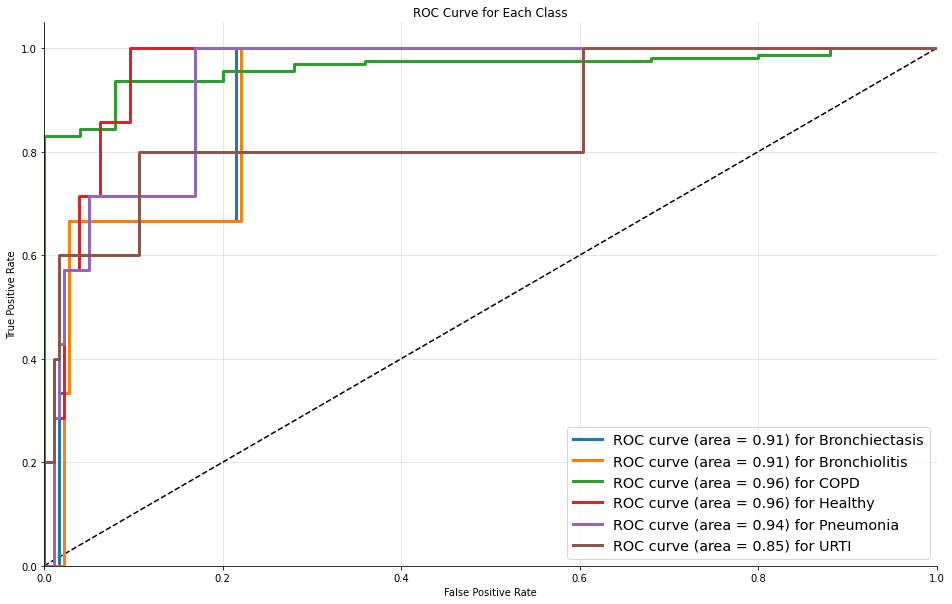

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.97      0.96      0.96       159
       Healthy       0.50      0.57      0.53         7
     Pneumonia       0.36      0.57      0.44         7
          URTI       0.40      0.40      0.40         5

      accuracy                           0.88       184
     macro avg       0.37      0.42      0.39       184
  weighted avg       0.88      0.88      0.88       184



In [ ]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[  0   0   1   0   2   0]
 [  0   0   1   0   1   1]
 [  1   0 152   2   3   1]
 [  1   0   0   4   1   1]
 [  0   0   3   0   4   0]
 [  0   1   0   2   0   2]]


Accuracy: 88%
Loss: 1.1027



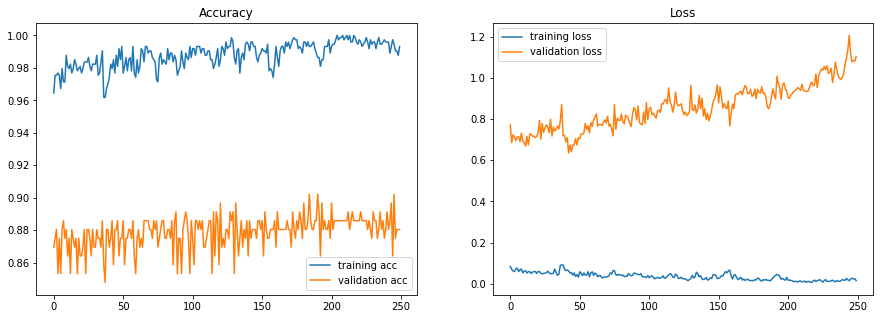

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()